# **The Heston Stochastic Volatility Model**

One of the major simplifying assumptions of the Black-Scholes-Merton model is the constant volatility. However, volatility in general is neither constant nor deterministic, it is in fact stochastic. One of the major advancements when it comes to financial modeling was achieved in the early 1990s with the introduction of the stochastic volatility model. One of the most popular models that fall into that category is that of Heston. The stochastis differential equations of the Heston model under risk-neutral dynamics are given as: 

$$
dS_t = rS_tdt+\sqrt{\nu_t}S_tdZ_t^1\\
d\nu_t = \kappa_\nu(\theta_\nu-\nu_t)dt + \sigma_\nu\sqrt{\nu_t}dZ_t^2 \\
dZ_t^1dZ_t^2 = \rho
$$
where the parameter $\rho$ represents the instantaneous correlation between the two standard Brownian motions $Z_t^1$,$Z_t^2$. This allows us to account for a stylized fact called the leverage effect, which in essence stats that volatility goes up in times of distress and goes down in times of a bull market. $S_t$ is the price of the asset, determined by a stochastic process. $\nu_t$ is the instantaneous variance (and a CIR process). $r$ is the risk-free interest rate. $\theta$ is the long variance, or long run average price variance (as $t$ tends to infinity, the expected value of $\nu_t$ thends to $\theta$). $\kappa$ is the rate at which $\nu_t$ reverts to $\theta$ and $\sigma$ is the volatility of the $\sqrt{\nu_t}$.

Using Fourier Transform (lewis lipton formula), we can write the price as:
$$
C(S,K,\tau)=e^{-r\tau}S-\frac{e^{-r\tau}K}{2\pi}\int_{-\infty}^\infty\frac{e^{(i\varphi+\frac{1}{2})X+\alpha(\varphi)-(\varphi^2+\frac{1}{4})\beta(\varphi)\nu}}{\varphi^2+\frac{1}{4}}d\varphi
$$
where
$$
\hat{\kappa}=\kappa-\frac{1}{2}\rho\sigma\\
X=\ln\left(\frac{S}{K}\right)\\
\zeta(\varphi)=\sqrt{\varphi^2\sigma^2(1-\rho^2)+2i\varphi\sigma\rho\hat{\kappa}+\hat{\kappa}^2\frac{1}{4}\sigma^2}\\
\psi_{\pm}=\mp(i\varphi\rho\sigma+\hat{\kappa})+\zeta(\varphi)\\
\alpha(\varphi)=-\frac{\kappa\theta}{\sigma^2}\left(\psi_+(\varphi)\tau+2\ln\left(\frac{\psi_-(\varphi)+\psi_+(\varphi)e^{-\zeta(\varphi)\tau}}{2\zeta(\varphi)}\right)\right)\\
\beta(\varphi)=\frac{1-e^{\zeta(\varphi)\tau}}{\psi_-(\varphi)+\psi_+(\varphi)e^{\zeta(\varphi)\tau}}
$$

We will start by importing the nessecary packages

In [79]:
import math
import pandas as pd
import datetime, os
import numpy as np
import numpy.random as npr
from pylab import plt, mpl

import threading

from scipy.stats import norm
from scipy import optimize
import scipy.integrate as integrate
import scipy.special as special 

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### **The Heston model**
We implement the above Heston Stochastic volatility model in order to generate our Heston prices (and later on our volatilities).

The following computes our Heston prices:

In [2]:
def heston_call(S, K, tau, r, kappa, theta, sigma, rho, nu, limit):
    X = np.log(S / K)
    kappahat = kappa - 0.5 * rho *sigma

    def Integrand(k):
        xi = np.sqrt(k**2*sigma**2*(1-rho**2) + 2j*k*sigma*rho*kappahat + \
                         kappahat**2 + (sigma**2)/4)
        psi_p = -(1j*k*rho*sigma + kappahat) + xi
        psi_m = (1j*k*rho*sigma + kappahat) + xi
        alpha = -((kappa*theta)/sigma**2) * \
              (psi_p*tau + 2*np.log((psi_m+psi_p*np.exp(-xi*tau))/(2*xi)))
        beta = (1-np.exp(-xi*tau)) / (psi_m + psi_p * np.exp(-xi*tau))

        numerator = np.exp((-1j*k+0.5)*X+alpha-(k**2+0.25)*beta*nu)
        integrall = np.real(numerator / (k**2+0.25))

        return integrall

    result = integrate.quad(lambda x: Integrand(x), -limit, limit)
    integrall = result[0]

    # compute Call price
    price = 1*S-K*np.exp(-r*tau)*integrall / (2*np.pi)

    return price

In [3]:
#Test (should give 4.1732)
heston_call(S=100, K=100, tau=1.0, r=.0, kappa=1.98, theta=0.108977**2, sigma=0.33, rho=0.025, nu=0.1197**2, limit=50)

4.1731689206535805

### **Heston implied volatility**
In order to create the implied volatility given the Heston model, we need to compute the BSM model as well. When having the BSM model for call prices, we can compute its implied volatility using some root finding method (below we implement both the Newton-Raphson-, Brent- and Bisection-method).

In [4]:
class bsm_call_option(object):
    '''
    Class for European call options in BSM model
    It's main purpose is calculating the implied volatility for the Heston model
    
    Attributes
    ==========
    S: float - Stock price
    K: float - Strike price
    tau: float - time to maturity 
    r: float - constant riske-free rate
    sigma: float - volatility
    
    Methods
    =======
    value: float - returns the present value of the call option
    vega: float - returns the vega of the option
    imp_vol: float - returns the implied volatility
    '''
    
    def __init__(self, S, K, tau, r, sigma):
        self.S = S
        self.K = K
        self.tau = tau
        self.r = r
        self.sigma = sigma
        
    def value(self):
        d1 = ((np.log(self.S / self.K) +
               (self.r + 0.5 * self.sigma ** 2) * self.tau) /
              (self.sigma * np.sqrt(self.tau)))
        d2 = ((np.log(self.S / self.K) +
               (self.r - 0.5 * self.sigma ** 2) * self.tau) /
              (self.sigma * np.sqrt(self.tau)))
        value = (self.S * norm.cdf(d1, 0.0, 1.0) -
                 self.K * np.exp(-self.r * self.tau) * norm.cdf(d2, 0.0, 1.0))
        return value
    
    '''
    ====================================================
    If you want to use the Newton-Raphson method instead
    ====================================================
    
    def vega(self):
        d1 = ((np.log(self.S / self.K) +
               (self.r + 0.5 * self.sigma ** 2) * self.tau) /
              (self.sigma * np.sqrt(self.tau)))
        vega = self.S * norm.pdf(d1, 0.0, 1.0) * np.sqrt(self.tau)
        return vega
    
    def imp_vol(self, C0, sigma_est=0.2, it=1000):
        option = bsm_call_option(self.S, self.K, self.tau, self.r, sigma_est)
        for i in range(it):
            option.sigma -= (option.value() - C0) / option.vega()
        return option.sigma
    '''
    
def bisection(S,K,tau,r,C0, it=10000, precision=1e-6):
    #lower bound and upper bound definition
    a = 1e-20
    b = 10
    m = (b+a) / 2
    count_iter = 1

    while count_iter <= it and math.fabs(b-a)>precision:
        #If f(a)*f(b)<0
        if (bsm_call_option(S, K, tau, r, a).value()-C0)*(bsm_call_option(S, K, tau, r, m).value()-C0)<0:
            b = m
        else:
            a = m
        m = (b+a) / 2
        count_iter += 1
    return m

'''
====================================================
If you want to use the Brents method instead
====================================================

def brentq():
    def bsm_imp_vol(x):
        return bsm_call_option(S, K, tau, r, x).value() - heston_call(S, K, tau, r, kappa, theta, sigma, rho, nu, limit)
    
    return scipy.optimize.brentq(bsm_imp_vol, -500, 500)
''';

In [5]:
#Test (should give 0.4105297)
bisection(S=100., K=120., tau=0.25, r=0., C0=2.3)

0.4105296730995178

#### **Example**

Insted of using some initial value (one often chooses the price shown in the market) for the call price in the BSM model, we can insted use the Heston model to calculate the call price and from that, calculate the implied vol.

Let's see an example with the strike price choosen as a range from 80-120:

In [6]:
K = np.linspace(80,120, 41)

S, theta, r, kappa, rho, nu, tau, sigma =100., 0.2**2, 0., 1., -0.5, 0.2**2, 0.25, 1.

#integrate from -400 to 400 for ease of computation in heston
limit = 400

implied_volatility = []
heston_prices = []
for i in range(41):
    Heston_C = heston_call(S, K[i], tau, r, kappa, theta, sigma, rho, nu, limit)
    heston_prices.append(Heston_C)

    if Heston_C > 0:
        imp_vol = bisection(S, K[i], tau, r, Heston_C) 
        implied_volatility.append(imp_vol)
    elif Heston_C <= 0:
        Heston_C = heston_call(S, K[i-1], tau, r, kappa, theta, sigma, rho, nu, limit)
        imp_vol = bisection(S, K[i-1], tau, r, Heston_C) 
        implied_volatility.append(imp_vol)

    if(i % 10) == 0:
        print('Generated {} implied volatilities'.format(i))

Generated 0 implied volatilities
Generated 10 implied volatilities
Generated 20 implied volatilities
Generated 30 implied volatilities
Generated 40 implied volatilities


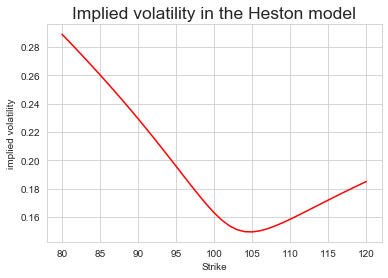

In [7]:
sns.set_style("whitegrid")
ax = sns.lineplot(x=K, y=implied_volatility, color='red')
ax.axes.set_title("Implied volatility in the Heston model", fontsize=17.5);
ax.set(xlabel="Strike", ylabel="implied volatility");

### **The Heston model dataset / parameters**
Lets create a dataset with pseudo-random numbers. Pseudo-random numbers build the basis for all simulation efforts. although quasi-random numbers which are based on sobol sequences have gained some popularity in finance, pseudo-random numbers still seem to be the benchmark.

#### **Update ( the following will first be implemented on the final dataset)**
According to Antoine [Modern Computational Finance: AAD and Parallel Simulations] it is considered best practice in finance to apply quasi-random numbers generated by Sobol’s algorithm in instead of (pseudo-)random numbers. The benefit of using sobol numbers is the lower discrepancy (they fill the space of possibilities more evenly). The lower discrepancy helps with faster convergance and more stable estimates of financial product values and risk sensitivities. Yet, pseudo-random numbers build the basis for most simulation efforts and is according to Hilpish [Python for finance] still the benchmark.

In [8]:
#Fix the seed value for reproducibility and fix the number of digits for printouts
npr.seed(42)
np.set_printoptions(precision=10, suppress=True)

#sample size
sample_size = 100000

#Time to maturity from 0.11 year to 1.1 years 
tau = npr.randint(40.15, 401.5+1, sample_size) / 365
#Risk free rate from almost 0 to 10%
r = npr.randint(1, 1000+1, sample_size) / 10000
#volatility of the variance (5% to 50%)
sigma = npr.randint(5, 50+1, sample_size) / 100
#Correlation (-90% to +0%)
rho = npr.randint(-9, 0+1, sample_size) / 10
#initial variance (5% to 50%)
nu = npr.randint(5, 50+1, sample_size) / 100
#Long term mean (5% to 50%)
theta = npr.randint(5, 50+1, sample_size) / 100
#Mean reversion speed 
kappa = npr.randint(10, 190+1, sample_size) / 100
#Spot price 
S = np.full(shape=sample_size,fill_value=1, dtype=np.int)
#Strikes 
K = np.arange(0.8, 1.3, 0.05)

#integrate from -400 to 400 for ease of computation
#(note that for lim=-200,200 the greeks tails were not pretty)
limit = 400

In [ ]:
%%time
#Vectorize both heston_call prices and the bisection in order to not use a for-loop
hc = np.vectorize(heston_call)
bs = np.vectorize(bisection)

#Initialize the implied volatility matrix with zeros
imp_vol = np.zeros((sample_size, len(K)))

#Create the implied volatilities
for i in range(len(K)):
    #heston_prices[:,i] = hc(S, K[i], tau, r, kappa, theta, sigma, rho, nu, limit)
    imp_vol[:,i] = bs(S, K[i], tau, r, hc(S, K[i], tau, r, kappa, theta, sigma, rho, nu, limit))
    
    
    print('Generated implied volatilities for K{} '.format(i+1))
    


Since the standard deviation (done when normalizing later on) is calculated by taking the sum of the squared deviations from the mean, a zero standard deviation can only be possible when all the values of a variable are the same (all equal to the mean). In this case, those variables have no discriminative power so they can be removed from the analysis. They cannot improve any classification, clustering or regression task. Many implementations will do it for you or throw an error about a matrix calculation. We will manually exclude S and the strikes K from our input datasets

In [ ]:
imp_vol_K1 = imp_vol[:,0]
imp_vol_K2 = imp_vol[:,1]
imp_vol_K3 = imp_vol[:,2]
imp_vol_K4 = imp_vol[:,3]
imp_vol_K5 = imp_vol[:,4]
imp_vol_K6 = imp_vol[:,5]
imp_vol_K7 = imp_vol[:,6]
imp_vol_K8 = imp_vol[:,7]
imp_vol_K9 = imp_vol[:,8]
imp_vol_K10 = imp_vol[:,9]

Options_output = pd.DataFrame({'imp vol K1': imp_vol_K1,
                               'imp vol K2': imp_vol_K2,
                               'imp vol K3': imp_vol_K3,
                               'imp vol K4': imp_vol_K4,
                               'imp vol K5': imp_vol_K5,
                               'imp vol K6': imp_vol_K6,
                               'imp vol K7': imp_vol_K7,
                               'imp vol K8': imp_vol_K8,
                               'imp vol K9': imp_vol_K9,
                               'imp vol K10': imp_vol_K10})


Options_input = pd.DataFrame({'tau': tau,
                              'r': r,
                              'sigma': sigma,
                              'rho': rho,
                              'nu': nu,
                              'theta': theta,
                              'kappa': kappa})


Check how the input and output dataframes look

In [11]:
Options_input.head(5)

,tau,r,sigma,rho,nu,theta,kappa
0,0.389041,0.0725,0.42,-0.7,0.14,0.28,1.34
1,1.063014,0.0540,0.26,-0.9,0.15,0.32,0.10
2,0.849315,0.0862,0.25,-0.3,0.30,0.33,0.18
3,0.400000,0.0663,0.19,-0.4,0.10,0.24,1.27
4,0.304110,0.0125,0.15,-0.4,0.47,0.30,1.03


In [12]:
Options_output.head(5)

,imp vol K1,imp vol K2,imp vol K3,imp vol K4,imp vol K5,imp vol K6,imp vol K7,imp vol K8,imp vol K9,imp vol K10
0,0.465840,0.461065,0.457325,0.454763,0.453567,0.453974,0.456266,0.460753,0.467746,0.477508
1,0.452110,0.447660,0.443780,0.440492,0.437832,0.435844,0.434583,0.434113,0.434506,0.435838
2,0.609475,0.611394,0.613735,0.616486,0.619639,0.623187,0.627122,0.631435,0.636120,0.641167
3,0.394791,0.395699,0.397553,0.400503,0.404731,0.410452,0.417897,0.427299,0.438851,0.452670
4,0.675798,0.675021,0.674384,0.673884,0.673524,0.673305,0.673234,0.673318,0.673566,0.673992


Lets print some descriptions/statistics of our input and output datasets

In [13]:
# show description of the input parameters
Options_input.describe().T

,count,mean,std,min,25%,50%,75%,max
tau,100000.0,0.602877,0.286517,0.109589,0.353425,0.60274,0.849315,1.09863
r,100000.0,0.050007,0.028821,0.000100,0.025000,0.05000,0.074900,0.10000
sigma,100000.0,0.275704,0.132872,0.050000,0.160000,0.28000,0.390000,0.50000
rho,100000.0,-0.450640,0.287171,-0.900000,-0.700000,-0.50000,-0.200000,0.00000
nu,100000.0,0.275403,0.132570,0.050000,0.160000,0.28000,0.390000,0.50000
theta,100000.0,0.275328,0.132627,0.050000,0.160000,0.28000,0.390000,0.50000
kappa,100000.0,0.999336,0.522829,0.100000,0.550000,1.00000,1.450000,1.90000


In [14]:
# show description of the output parameters
Options_output.describe().T

,count,mean,std,min,25%,50%,75%,max
imp vol K1,100000.0,0.545408,0.110356,0.230112,0.465741,0.557632,0.634090,0.774013
imp vol K2,100000.0,0.544427,0.111075,0.224001,0.464409,0.556739,0.633645,0.776690
imp vol K3,100000.0,0.543962,0.111692,0.218844,0.463833,0.556353,0.633543,0.780029
imp vol K4,100000.0,0.544055,0.112151,0.216485,0.463756,0.556364,0.633820,0.783464
imp vol K5,100000.0,0.544769,0.112377,0.197013,0.464646,0.557104,0.634453,0.786994
imp vol K6,100000.0,0.546195,0.112268,0.172993,0.466242,0.558397,0.635397,0.790617
imp vol K7,100000.0,0.548450,0.111698,0.152198,0.468781,0.560251,0.637027,0.794331
imp vol K8,100000.0,0.551672,0.110565,0.147068,0.472504,0.562695,0.638949,0.798136
imp vol K9,100000.0,0.555969,0.108899,0.159058,0.477620,0.565917,0.641621,0.802028
imp vol K10,100000.0,0.561378,0.106901,0.165031,0.485103,0.569953,0.644881,0.806006


In [ ]:
#Check if there are unknown values
'''
Options_input.isna().sum()
Options_output.isna().sum()
'''

In [15]:
#Shape of input and output data
print("input shape: ", Options_input.shape)
print("output shape: ", Options_output.shape)

input shape:  (100000, 7)
output shape:  (100000, 10)


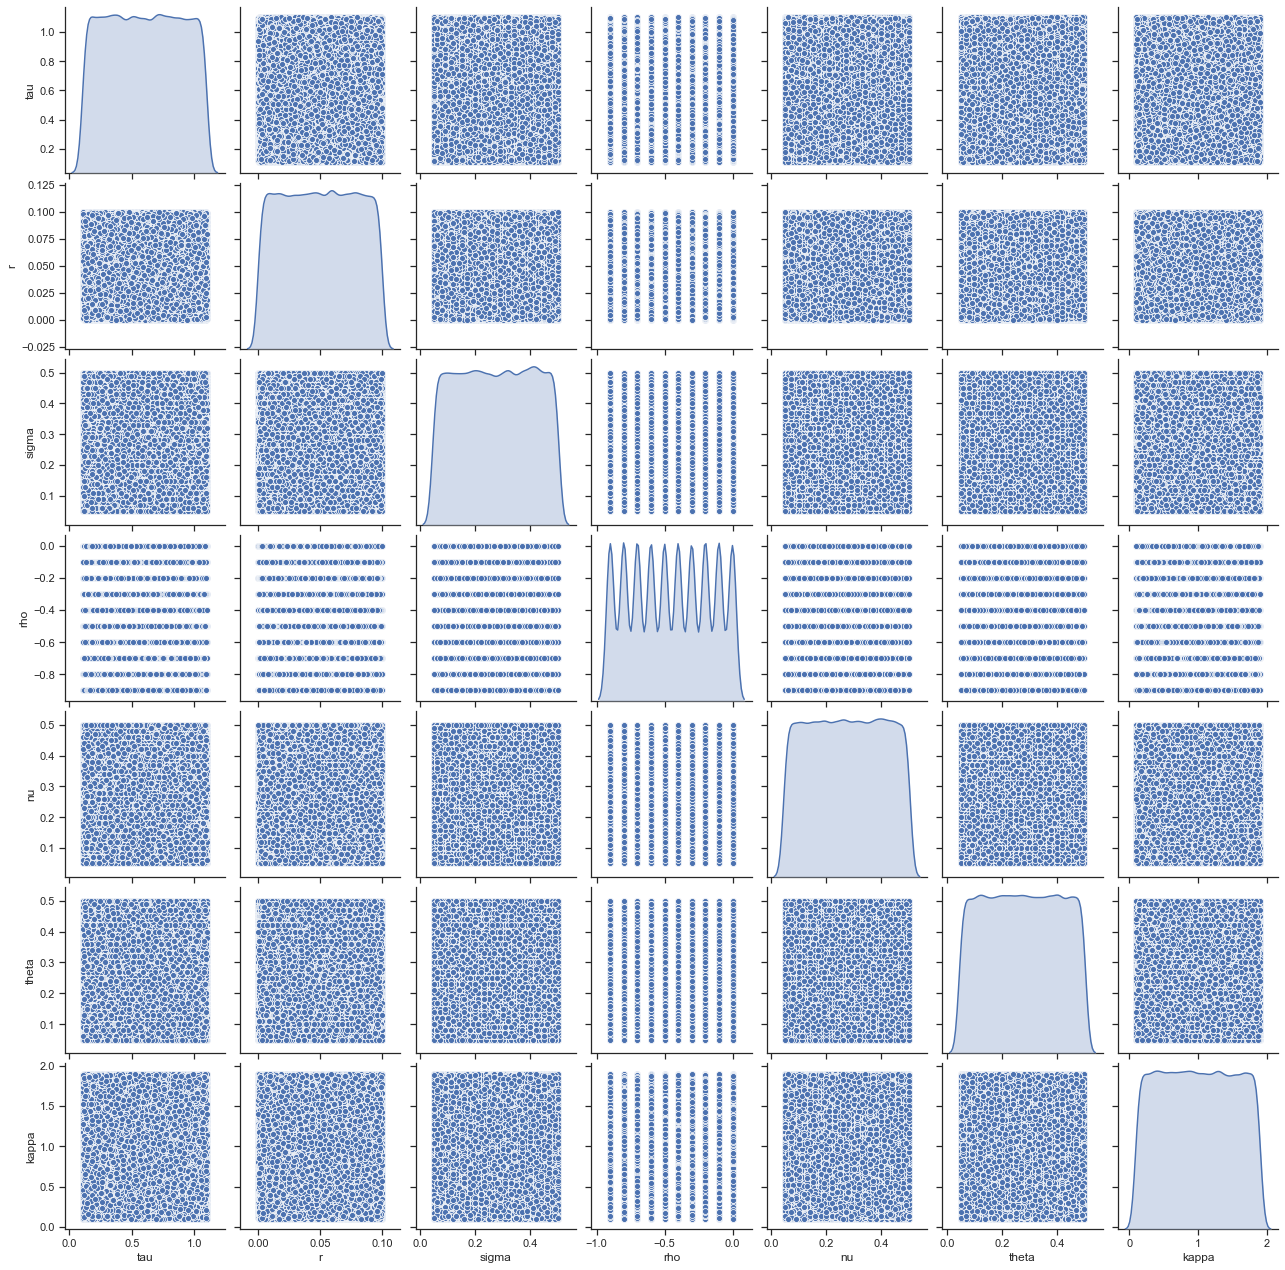

In [16]:
#distribution of input data
sns.set(style="ticks", color_codes=True)

Options_input_pairplot = sns.pairplot(Options_input, diag_kind="kde")

plt.show();

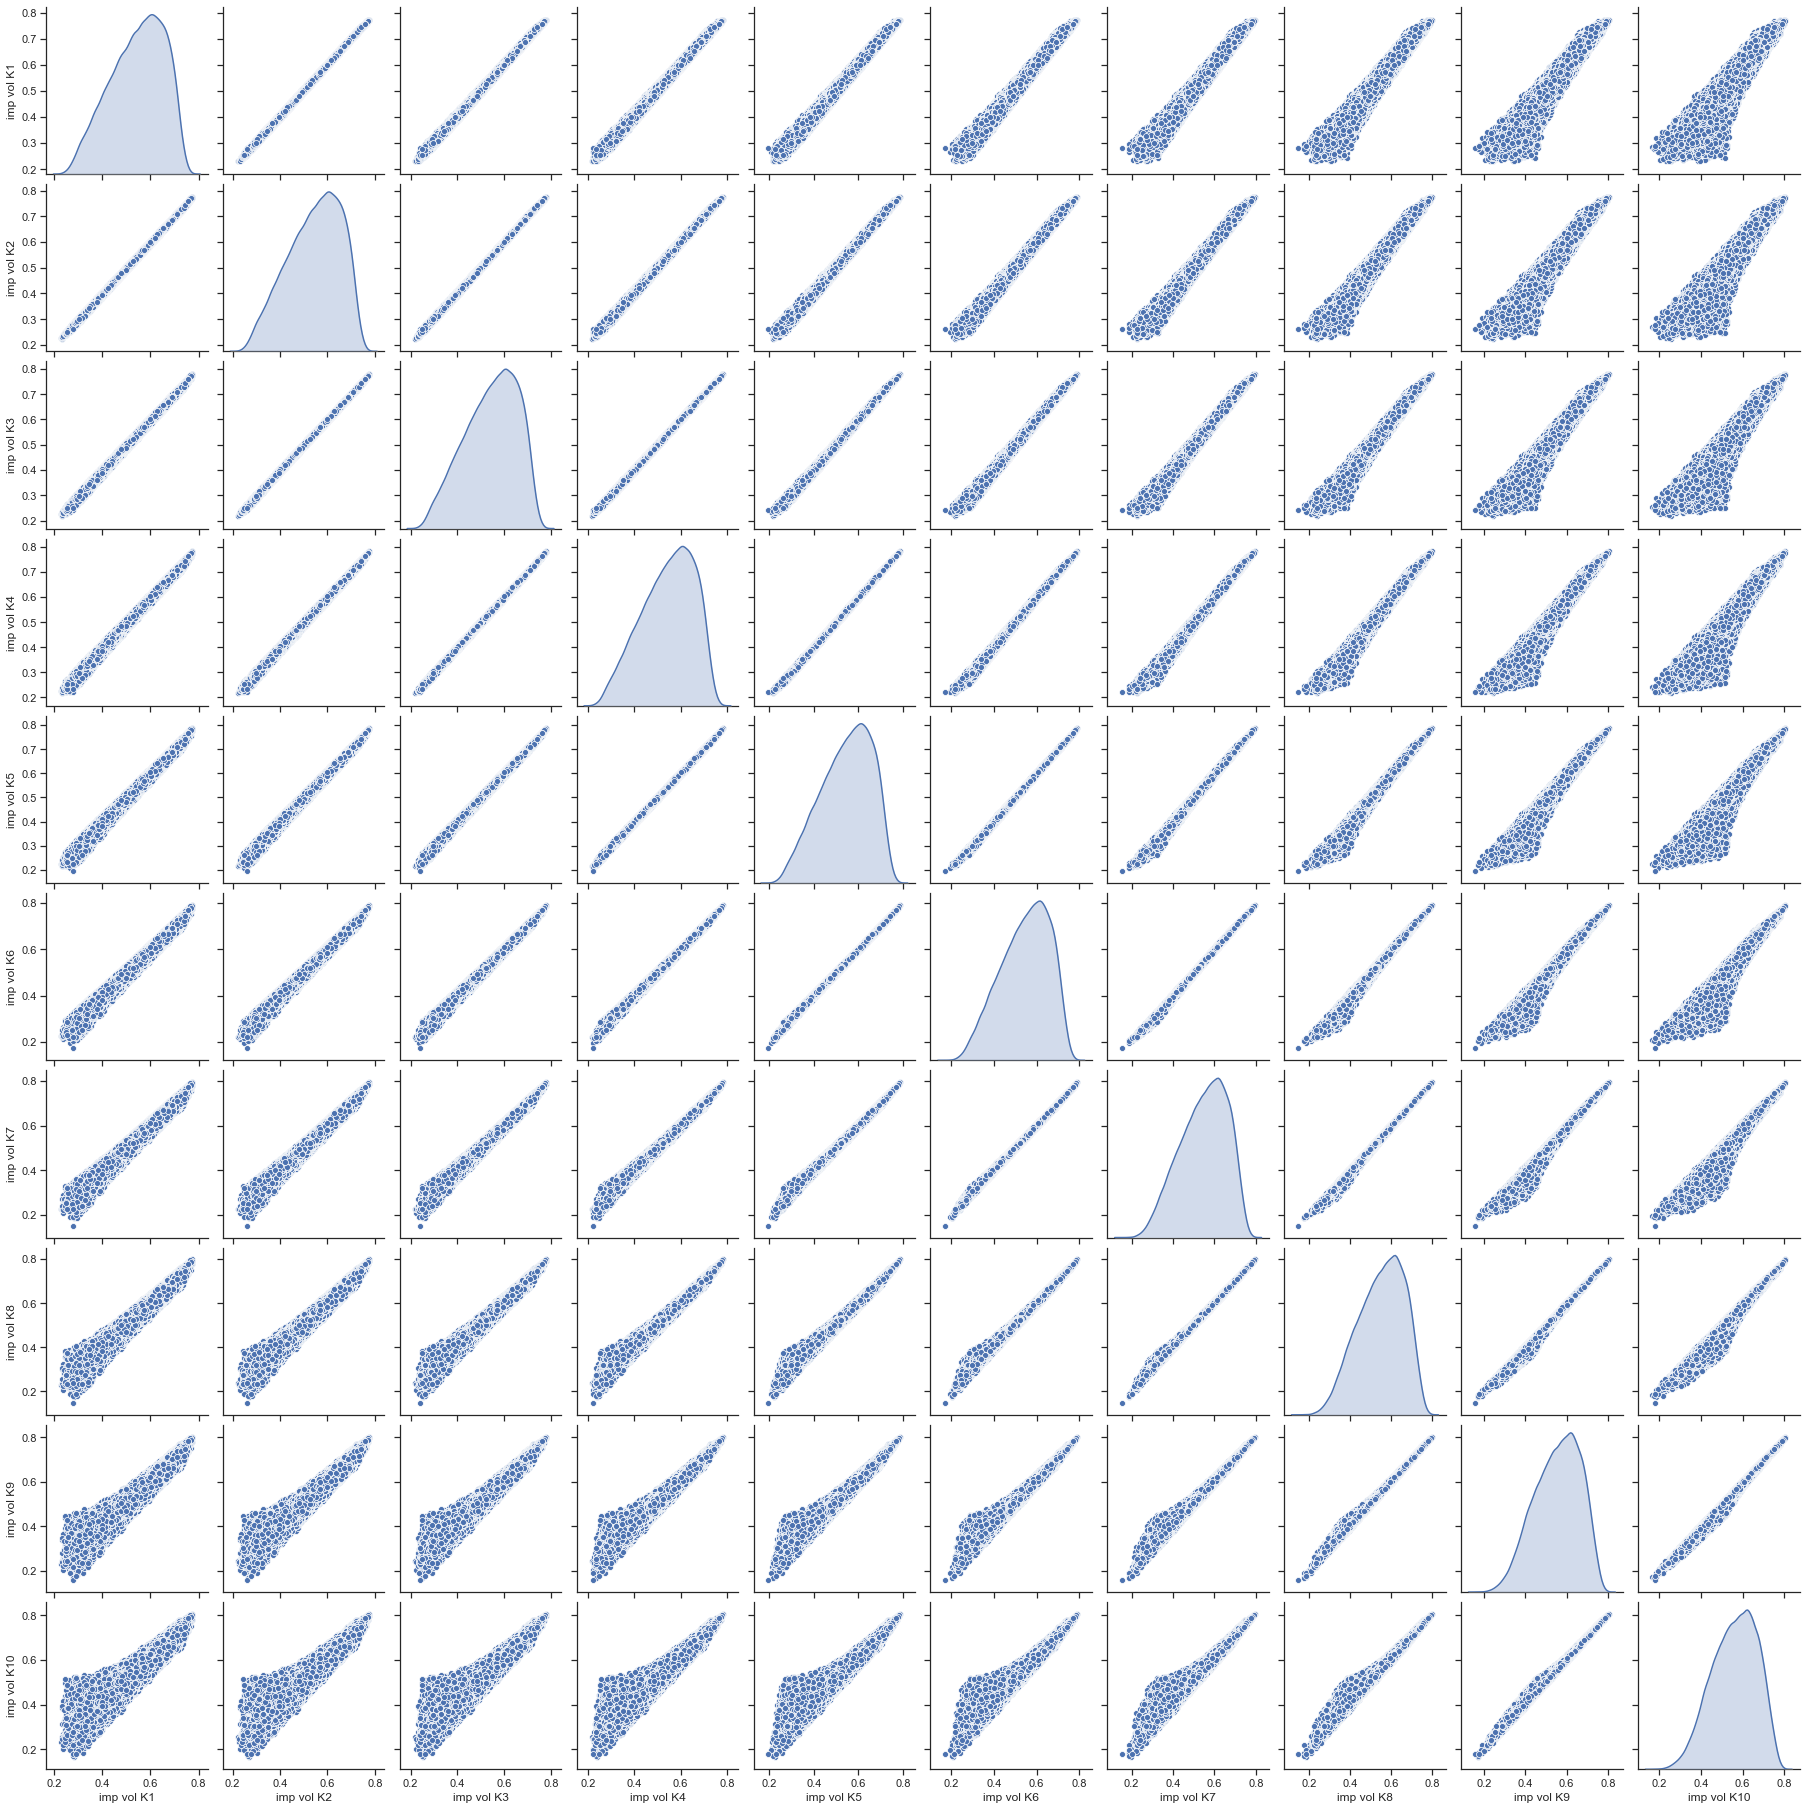

In [46]:
#distribution of output data
sns.set(style="ticks", color_codes=True)

Options_output_pairplot = sns.pairplot(Options_output, diag_kind="kde")

plt.show();

Quick graph of the volatility skew from our generated dataset

In [19]:
test_options_output = Options_output[1:2].T.values
test_options_output.reshape(10,)
test_options_output = np.array(test_options_output)

test_K = K.reshape(10,1)
test_K = np.array(test_K)

test_plot = np.concatenate((test_K, test_options_output), axis=1)

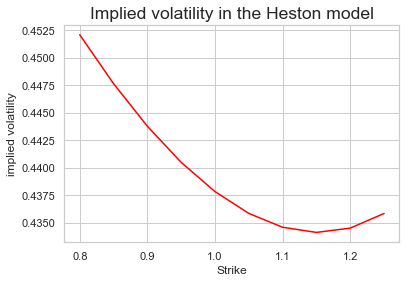

In [20]:
sns.set_style("whitegrid")
ax = sns.lineplot(x=test_plot[:,0], y=test_plot[:,1], color='red')
ax.axes.set_title("Implied volatility in the Heston model", fontsize=17.5);
ax.set(xlabel="Strike", ylabel="implied volatility");

Lets save the dataframe as a CSV so we dont need to run it again, but can just load it when needed.

In [44]:
'''
Options_input.to_csv("/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_data_input.csv")
Options_output.to_csv("/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Heston_data_output.csv")
'''

#To read the import the csv-file, use:
raw_Options_input = pd.read_csv (r"/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Options_input.csv")
raw_Options_output = pd.read_csv (r"/Users/Marcklein/Desktop/Master Thesis/Option pricing using Neural Networks/Python/Heston/Options_output.csv")

#Creates some unnamed column in the beginning, delete it:
del raw_Options_input['Unnamed: 0']
del raw_Options_output['Unnamed: 0']


In [45]:
Options_input = raw_Options_input.copy()
Options_output = raw_Options_output.copy()

### **Data preparation**

We split our dataset into a training set and a test set (validation set is taken from the training set during model.fit).

In [70]:
# 90% for training and validating
train_dataset = Options_input.sample(frac=0.9, random_state=42)
test_dataset = Options_input.drop(train_dataset.index)

train_labels = Options_output.sample(frac=0.9, random_state=42)
test_labels = Options_output.drop(train_labels.index)

Check the overall statistics

In [71]:
train_stats = train_dataset.describe().T

Separate the target values from the input values. These values are the values that we will train the model to predict. We will also normalize the data due to reasons described in the thesis

In [72]:
#normalize the data
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset).values
normed_test_data = norm(test_dataset).values

#make the labels into numpy array just like the normed training data
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

'''
#standardise the data
scaler = StandardScaler()
normed_train_data = scaler.fit_transform(train_dataset)
normed_test_data = scaler.fit_transform(test_dataset)
'''

#check the shapes
print("Input train data:", normed_train_data.shape, " Output train data:", train_labels.shape)
print("Input test data:", normed_test_data.shape, " Output test data:", test_labels.shape)

Input train data: (90000, 7)  Output train data: (90000, 10)
Input test data: (10000, 7)  Output test data: (10000, 10)


## **The model**

Now let's build the neural network with one hidden layer using tensorflow and a Sequential API.

Note: This model has been primarily chosen based on the same hyperparameters as in McGhee's paper. When doing hyperparameter optimizations (done in another document) it may not prove to be the fastest nor the most accurate network.

In [74]:
input_size = len(train_dataset.keys())
output_size = 10
hidden_layer_size = 1000

def build_model():
    model = keras.models.Sequential([
            #Layer to be used as an entry point into a Network
            keras.layers.InputLayer(input_shape=[len(train_dataset.keys())]),
            #Dense layer
            keras.layers.Dense(hidden_layer_size, activation='relu'),
            #activation function is linear since we are doing regression
            keras.layers.Dense(output_size, activation='linear')
                                ])

    model.compile(optimizer='Adam', 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error', 'mean_squared_error'])

    return model

In [75]:
model = build_model()

Inspect the model using .summary to get a simple description of the model (there should be no non-trainable parameters)

In [76]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1000)              8000      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                10010     
Total params: 18,010
Trainable params: 18,010
Non-trainable params: 0
_________________________________________________________________


Now, try out the model. Take a batch of 10 examples from the training data and call model.predict on it. There should be no NaN, otherwise something is wrong

In [77]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.0602491   ,  0.12200551  ,  0.15221208  ,  0.070547104 ,
        -0.0045668827, -0.0062973173, -0.085181706 ,  0.2607581   ,
        -0.1926479   , -0.049816143 ],
       [-0.0059337337,  0.013060278 ,  0.14815696  , -0.11493765  ,
        -0.07973984  , -0.061620552 , -0.16378418  , -0.08532438  ,
        -0.04674926  ,  0.046505865 ],
       [ 0.07599979  , -0.08532455  ,  0.0030427147, -0.06898398  ,
        -0.05117006  , -0.011832796 , -0.08948645  , -0.013185112 ,
        -0.012868537 , -0.05637061  ],
       [-0.018088032 ,  0.03403924  ,  0.15590943  ,  0.11732036  ,
         0.0796817   , -0.034738623 , -0.016338654 ,  0.08243323  ,
        -0.21934038  , -0.04800811  ],
       [ 0.078662485 ,  0.027788244 ,  0.018214177 , -0.22707748  ,
        -0.14324163  , -0.17089929  , -0.16734844  ,  0.24177338  ,
        -0.07878197  , -0.15824687  ],
       [ 0.04827609  ,  0.075365685 , -0.022763092 ,  0.0623075   ,
         0.025956322 ,  0.0036409944,  0.0095850825, -0.0

Train the model for #max_epochs epochs, and record the training and validation accuracy in the history object.

In [80]:
%%time

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

batch_size = 1000
max_epochs = 100000

#stops training if the val_loss has not improved over the last #number of epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=100)

#log our training in order to display it to tensorboard (provides great visual effects)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#fit the model and save it under history
history = model.fit(normed_train_data, 
         train_labels, 
         batch_size=batch_size, 
         epochs=max_epochs,
         validation_split=0.2,
         verbose=0,
         callbacks=[early_stopping, PrintDot(), tensorboard_callback])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...................CPU times: user 28min 57s, sys: 8min 17s, total: 37min 14s
Wall time: 10min 43s


In [81]:
%tensorboard --logdir logs/fit

Visualize the model's training progress using the stats stored in the history object.

In [82]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
514,8.846957e-07,0.000743,8.846956e-07,6.355133e-07,0.000665,6.355133e-07,514
515,4.734281e-07,0.000538,4.734281e-07,4.365845e-07,0.000522,4.365845e-07,515
516,1.112717e-06,0.000828,1.112717e-06,1.250242e-06,0.000947,1.250242e-06,516
517,6.827270e-07,0.000622,6.827268e-07,2.133969e-07,0.000345,2.133969e-07,517
518,2.285840e-07,0.000358,2.285840e-07,1.876111e-06,0.001274,1.876111e-06,518


Make a simple plot of the training (there is no need for this as tensorboard does it already, but still great visualizer for printing)

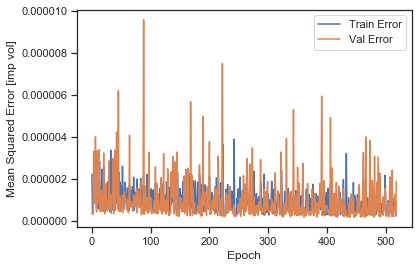

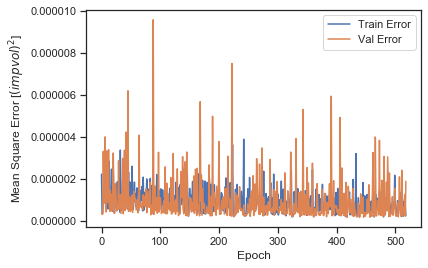

In [91]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error [imp vol]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0.,0.00002])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$(imp vol)^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

The graph shows that on the validation set, the average error is usually around +/- 1.876111e-06

Let's see how well the model generalizes by using the test set, which we did not use when training the model. This tells us how well we can expect the model to predict when we use it in the real world (we print the mean_squared_error).

In [84]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Squared Error: {:5.10f} imp vol".format(mse))

Testing set Mean Squared Error: 0.0000019088 imp vol


Finally, predict the implied volatility values using data in the testing set

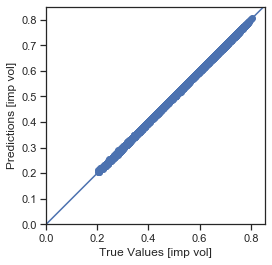

In [85]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [imp vol]')
plt.ylabel('Predictions [imp vol]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])